### Artificial Intelligence 601.464
### Project #2

### Before You Begin...
00. We're using a Jupyter Notebook environment (tutorial available here: https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html),
01. Read the entire notebook before beginning your work, and
02.  Check the submission deadline on Gradescope.


### General Directions for this Assignment
00. Output format should be exactly as requested,
01. Functions should do only one thing,
02. Keep functions to 20 lines or less (empty lines are fine, there's leeway, but don't blatantly ignore this),
03. Add docstring to all functions,


### Before You Submit...
00. Re-read the general instructions provided above, and
01. Hit "Kernel"->"Restart & Run All". The first cell that is run should show [1], the second should show [2], and so on...
02. Submit your notebook (as .ipynb, not PDF) using Gradescope, and
03.  Do not submit any other files.

### Problem #0: Conda and Imports

We will be using non-standard libaries for this assignment. We will be using **gymnansium** a python library for Reinforcement Learning simulations (we will not need RL for this project), **numpy** for fast vector math, **matplotlib** for graphing, and **pillow** for rendering. 

***Installing Imports***

To ensure consistency with outputs, we recommend using a python environment to install these libraries. We recommend using conda. Miniconda is sufficient: https://www.anaconda.com/docs/getting-started/miniconda/main

Once conda is installed, create your own environment by running:

```conda create -n "ai_hw2" python==3.13.9```

This ensures your python version aligns with other machines (our autograder) and has a clean install of python.
To install your libraries:

```
conda activate "ai_hw2"
pip install gymnasium gymnasium[other] ipykernel matplotlib
```
--By default gymnasium should require numpy and pillow, so we can omit that in our install.

Now we select our "ai_hw2" kernel when running our code and we have a consistent python run!

## Problem #1: Boids Rule Simulation

### 1) Imports

In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from PIL import Image, ImageDraw
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import os

### Mini-Aside: Numpy

`numpy` is a library used for fast vector math! Instead of using lists which can be slow and memory intensive we define arrays using 

`x = np.array([1, 2, 3])`

- x is now an array of [1,2,3]! 
- We can also consider this a vector (x,y,z)
- Arrays are faster since they are contiguous in memory!

**Defining Matrices**

We can now create efficient matrices by doing the following:

- `x = np.zeros(2)` -- creates an 1x2 matrix of zeros
- `y = np.ones((3,3))` -- creates a 3x3, matrix of ones
- `z = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])` -- creates a 3x3 matrix of predefined values.

**Vector Math**

- We can add matrices together by using the `+` operator. 
- We can multiply them elementwise by using the `*` operator. You can also scale matrices with a scalar using the same operator!
- We can mutiply matrices by using the `@` operator (not necessary yet, but helpful to know!)
- Numpy supports linear algera functions like norm, inverse, and transpose!

**Numpy dtypes**
- Since arrays are contigous in memory, arrays must be of one type. We cannot have floats and ints in the same array...
- By default numpy assigns arrays to be `np.float32` which is a float with 32 bits. This is ideal for fast physics calculations that require precision and speed. 
    - Other common types are `np.int32` and `np.long` for integer values and `np.float16` and `np.float64` for more optimized or fine-grained tasks.
- We can define our array types by passing an additional argument 

    - `y = np.ones((3,3), dtype=np.float32)` -- 3x3 matrix of floats

- When using math oprators arrays can cast when needed, but it is good practice to keep your array types consistent!

In [2]:
x = np.zeros(2)
y = np.ones((3,3), dtype=np.float32)
z = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print("Addition\n", y+z)
print("Multiplication\n", y*z)
print("Matrix multiplication\n", y@z)
print("Scalar multiplication\n", z*2)
# print(x+y) NOT POSSIBLE, DIMENSION MISMATCH
k = np.ones((3,3), dtype=np.int32)
print("Addition with int32\n", k+y)

Addition
 [[ 2.  3.  4.]
 [ 5.  6.  7.]
 [ 8.  9. 10.]]
Multiplication
 [[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
Matrix multiplication
 [[12. 15. 18.]
 [12. 15. 18.]
 [12. 15. 18.]]
Scalar multiplication
 [[ 2  4  6]
 [ 8 10 12]
 [14 16 18]]
Addition with int32
 [[2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]]


### 2) Vector helper functions 

Vector math for:

- Normalizing direction vectors (unit)
- Limiting acceleration magnitude (clip_vec)
= Combining multiple “forces” into a single acceleration (combine_accels)

You **do not** need to modify these.

In [3]:

def safe_norm(v: np.ndarray, eps=1e-8) -> float:
    """
    Args:
        v: vector to compute norm of
        eps: small value to add for numerical stability
    Returns:
        ||v|| with epsilon to avoid divide-by-zero.
    """
    return float(np.linalg.norm(v) + eps)

def unit(v: np.ndarray) -> np.ndarray:
    """
    Args:
        v: vector to compute unit vector of
    Returns:
        Return unit vector in direction of v (or zeros if v is ~0).
    """
    n = safe_norm(v)
    if n <= 1e-7:
        return np.zeros_like(v, dtype=np.float32)
    return (v / n).astype(np.float32)

def clip_vec(v: np.ndarray, max_mag: float) -> np.ndarray:
    """
    Args:        
        v: vector to clip
        max_mag: maximum magnitude
    Returns:
        Clip vector magnitude to max_mag (direction preserved).
    """
    n = safe_norm(v)
    if n <= max_mag:
        return v.astype(np.float32)
    return (v * (max_mag / n)).astype(np.float32)



### 3) Boids helper functions 

- Repulsion: move away from nearby swarm neighbors
- Attraction: move toward the leader
- Obstacle avoidance: push away if near/inside obstacle region
These functions convert Boids ideas into acceleration vectors.

<span style="color: red;"> Modify `combine_acccels`, `repulsion_accel` and `attraction_accel`.
You will use them in the TODOs later!</span>

In [4]:
def combine_accels(accels:list[np.ndarray], amax:float) -> np.ndarray:
    """
    Args:
        accels: list of acceleration vectors to combine
        amax: maximum allowed acceleration magnitude
    Returns:
        Sum a list of acceleration vectors and clip to amax.
    """
    if len(accels) == 0:
        return np.zeros(2, dtype=np.float32)

    total = np.zeros_like(accels[0], dtype=np.float32)

    for a in accels:
        total += a.astype(np.float32)

    return clip_vec(total, amax)

def repulsion_accel(my_pos: np.ndarray, neighbor_positions: np.ndarray, radius: float, gain: float) -> np.ndarray:
    """
    Repulsion: sum of push-away vectors from neighbors within 'radius'.
    Args:
        my_pos: my position
        neighbor_positions: array of neighbor positions
        radius: distance within which to repel neighbors
        gain: strength of repulsion
    Returns:
        Returns an acceleration vector.
    """
    accel = np.zeros(2, dtype=np.float32)

    for neighbor in neighbor_positions:
        offset = my_pos - neighbor
        dist = safe_norm(offset)

        if dist <= radius:
            accel += unit(offset)

    return (gain * accel).astype(np.float32)

def attraction_accel(my_pos: np.ndarray, leader_pos: np.ndarray, gain: float) -> np.ndarray:
    """
    Attraction: pull toward the leader.
    Args:
        my_pos: agent position
        leader_pos: leader position
        gain: strength of attraction
    Returns:
        Returns an acceleration vector.
    """
    direction = leader_pos - my_pos
    return (gain * unit(direction)).astype(np.float32)

def obstacle_avoid_accel(my_pos: np.ndarray, rect: tuple, avoid_dist: float, gain: float) -> np.ndarray:
    """
    Obstacle avoidance for axis-aligned rectangle rect=(x0,y0,x1,y1).
    If within avoid_dist of the rectangle (including inside), push away.
    Args:
        my_pos: agent position
        rect: rectangle defined as (x0, y0, x1, y1)
        avoid_dist: distance within which to avoid the rectangle
        gain: strength of avoidance
    Returns:
        Returns an acceleration vector.
    """
    x0, y0, x1, y1 = rect
    closest = np.array([np.clip(my_pos[0], x0, x1),
                        np.clip(my_pos[1], y0, y1)], dtype=np.float32)
    away = (my_pos - closest).astype(np.float32)
    d = safe_norm(away)

    if d <= 1e-6:
        left, right = my_pos[0] - x0, x1 - my_pos[0]
        top, bottom = my_pos[1] - y0, y1 - my_pos[1]
        m = min(left, right, top, bottom)
        if m == left:
            away = np.array([-1.0, 0.0], dtype=np.float32)
        elif m == right:
            away = np.array([1.0, 0.0], dtype=np.float32)
        elif m == top:
            away = np.array([0.0, -1.0], dtype=np.float32)
        else:
            away = np.array([0.0, 1.0], dtype=np.float32)
        d = safe_norm(away)

    if d > avoid_dist:
        return np.zeros(2, dtype=np.float32)
    return (gain * unit(away)).astype(np.float32)


### Gymnasium Environment 
Gym environment is just a standardized simulator API used to visualize your robot and swarm:
- reset() initializes positions/velocities
- step(action) applies accelerations and updates physics
- render() draws the current world

<span style="color: red;">You **do not** need to modify ENV</span>

Gynasium Basics: **Action Space vs. Observation Space**

Observation Space is our agents data relative to the world. In Reinforcement Learning, this is what our agent is allowed to see. We do not modify manually, we only read this one. Here we observe each agents position (x,y) and velocity (vx, vy).

$$\text{Observation Space} = \begin{bmatrix}
                        x_1 & y_1 & v_{x1} & v_{y1} \\
                        x_2 & y_2 & v_{x2} & v_{y2} \\
                        x_3 & y_3 & v_{x3} & v_{y3} \\
                        x_4 & y_4 & v_{x4} & v_{y4} \\
                        x_5 & y_5 & v_{x5} & v_{y5} \\
                    \end{bmatrix}$$

Action Space describes our agents next move. In Reinforcement Learning, this is what our agent is allowed to do. We modify this one in our policy. Here we modify each agents acceleration (ax, ay).
$$\text{Action Space} = \begin{bmatrix}
                    a_{x1} & a_{y1} \\
                    a_{x2} & a_{y2} \\
                    a_{x3} & a_{y3} \\
                    a_{x4} & a_{y4} \\
                    a_{x5} & a_{y5} \\
                \end{bmatrix}$$

In [5]:
class BoidsEnv(gym.Env):
    """
    5 agents total:
      idx 0 = leader
      idx 1..4 = swarm

    Observation: (5,4) array: [x, y, vx, vy]
    Action:      (5,2) array: [ax, ay]
    Reward: always 0 (ignored) (No RL here, just a simulation environment)
    """
    metadata = {"render_modes": ["rgb_array"], "render_fps": 30}

    def __init__(self, render_mode="rgb_array", w=500, h=500, dt=1.0,
                 vmax=6.0, amax=1.5, max_steps=300):
        super().__init__()
        self.render_mode = render_mode
        self.w, self.h = int(w), int(h)
        self.dt = float(dt)
        self.vmax = float(vmax)
        self.amax = float(amax)
        self.max_steps = int(max_steps)

        self.observation_space = spaces.Box(low=-1e9, high=1e9, shape=(5, 4), dtype=np.float32)
        self.action_space = spaces.Box(low=-self.amax, high=self.amax, shape=(5, 2), dtype=np.float32)

        self.steps = 0
        self.obstacles = [(150, 150, 350, 350)]
        self.goal = np.array([450, 75], dtype=np.float32)
        self.agents = np.zeros((5, 4), dtype=np.float32) # This will hold [x,y,vx,vy] for each agent

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.steps = 0
        self.agents[:] = 0.0

        # Initialize leader and swarm in a cluster near the bottom-left corner
        self.agents[0, :2] = np.array([80, 450], dtype=np.float32)
        for i in range(1, 5):
            self.agents[i, :2] = np.array([80 + 20*i, 450], dtype=np.float32)

        return self.agents.copy(), {}

    def _clip_speed(self):
        """Clip each agent speed to vmax."""
        v = self.agents[:, 2:4]
        speed = np.linalg.norm(v, axis=1, keepdims=True) + 1e-8
        factor = np.minimum(1.0, self.vmax / speed)
        self.agents[:, 2:4] = v * factor

    def _bounce_walls(self):
        """Bounce off walls and keep agents inside [0,w]x[0,h]."""
        x, y = self.agents[:, 0], self.agents[:, 1]
        hitL, hitR = x < 0, x > self.w
        hitT, hitB = y < 0, y > self.h

        self.agents[hitL, 0] = 0
        self.agents[hitR, 0] = self.w
        self.agents[hitT, 1] = 0
        self.agents[hitB, 1] = self.h

        self.agents[hitL | hitR, 2] *= -1
        self.agents[hitT | hitB, 3] *= -1

    def _push_out_of_obstacles(self):
        """Physics correction so agents do not remain inside obstacle."""
        for rect in self.obstacles:
            x0, y0, x1, y1 = rect
            for i in range(5):
                x, y = self.agents[i, 0], self.agents[i, 1]
                if (x0 <= x <= x1) and (y0 <= y <= y1):
                    left, right = x - x0, x1 - x
                    top, bottom = y - y0, y1 - y
                    m = min(left, right, top, bottom)
                    if m == left:
                        self.agents[i, 0] = x0 - 1
                        self.agents[i, 2] *= -1
                    elif m == right:
                        self.agents[i, 0] = x1 + 1
                        self.agents[i, 2] *= -1
                    elif m == top:
                        self.agents[i, 1] = y0 - 1
                        self.agents[i, 3] *= -1
                    else:
                        self.agents[i, 1] = y1 + 1
                        self.agents[i, 3] *= -1

    def step(self, actions: np.ndarray):
        """
        Apply accelerations, integrate physics, and handle boundaries.
        Args:
            actions: (5,2) array of accelerations for each agent
        Returns:
            obs: (5,4) array of agent states after step
            reward: always 0.0 (No RL)
            terminated: True if all agents are within 50 units of the goal
            truncated: True if max_steps have been reached
            info: empty dict
        """
        # Convert actions to numpy array and clip to amax
        actions = np.asarray(actions, dtype=np.float32)
        actions = np.clip(actions, -self.amax, self.amax)

        # Apply action to velocities and integrate positions
        self.agents[:, 2:4] += actions * self.dt
        self._clip_speed()
        self.agents[:, 0:2] += self.agents[:, 2:4] * self.dt

        # Handle boundaries and obstacles
        self._bounce_walls()
        self._push_out_of_obstacles()

        # Check termination and truncation conditions
        self.steps += 1
        terminated = np.allclose(self.agents[:, :2], self.goal, atol=50)
        truncated = (self.steps >= self.max_steps)

        return self.agents.copy(), 0.0, terminated, truncated, {}

    def render(self):
        """
        Render an RGB frame using PIL
        Returns an (H,W,3) uint8 array representing the RGB image.
        """
        # Create white background image
        img = Image.new("RGB", (self.w, self.h), (255, 255, 255))
        d = ImageDraw.Draw(img)

        # Draw obstacles as gray rectangles
        for (x0, y0, x1, y1) in self.obstacles:
            d.rectangle([x0, y0, x1, y1], fill=(40, 40, 40))

        # Draw goal as a green circle
        gx, gy = float(self.goal[0]), float(self.goal[1])
        d.ellipse([gx-50, gy-50, gx+50, gy+50], outline=(0, 200, 0), width=3)

        # Draw agents (leader in blue, swarm in orange)
        for i in range(5):
            x, y = float(self.agents[i, 0]), float(self.agents[i, 1])
            r = 10 if i == 0 else 8
            color = (0, 120, 255) if i == 0 else (255, 140, 0)
            d.ellipse([x-r, y-r, x+r, y+r], fill=color)

        return np.array(img, dtype=np.uint8)

## Boids Policy

At each timestep, every agent chooses an acceleration vector.
The leader accelerates toward its next waypoint (path-following)
Each swarm agent accelerates based on Boids forces:

- **Repulsion from other swarm agents**
- **Attraction to the leader**
- **Obstacle avoidance**

<span style="color: green;">**Note: Leader _does not_ have repulsion, attraction or collision to swarm!**</span>

This is going to determine how the butterflies decide to move! 
Complete the #TODOS

In [6]:
class BoidsPolicy:
    """
    Leader:
      - follows waypoints
      - obstacle avoidance

    Swarm:
      - repulsion from other swarm agents
      - attraction to leader
      - obstacle avoidance
    """
    def __init__(self):
        self.wpt_idx = 0
        self.waypoints = [(80, 100), (450, 75)]

    def reset(self):
        """Reset internal waypoint index."""
        self.wpt_idx = 0

    def leader_action(self, obs: np.ndarray, obstacle_rect: tuple, amax: float) -> np.ndarray:
        """
        Follow waypoints with obstacle avoidance.
        Args:
            obs: (5,4) array of agent states
            obstacle_rect: rectangle to avoid (x0,y0,x1,y1)
            amax: maximum acceleration magnitude
        Returns:
            Acceleration vector for the leader agent.
        """
        # Get leader position
        pos = obs[0, :2]

        # Check if we are close to the current waypoint and switch to next
        if self.wpt_idx < len(self.waypoints) - 1:
            if np.allclose(pos, self.waypoints[self.wpt_idx], atol=18):
                self.wpt_idx += 1
        target = self.waypoints[self.wpt_idx]

        # Simple proportional controller toward the target waypoint
        a_goal = ((target - pos) * 0.05).astype(np.float32)

        # Obstacle avoidance
        a_avoid = obstacle_avoid_accel(pos, obstacle_rect, avoid_dist=40.0, gain=2.0)
        return combine_accels([a_goal, a_avoid], amax)


    def swarm_action(self, obs: np.ndarray, agent_idx: int, obstacle_rect: tuple, amax: float) -> np.ndarray:
        """
        TODO: Finish this docstring
        Compute acceleration for one swarm agent using Boids rules.
        Args:
            obs (np.ndarray):
            agent_idx (int):
            obstacle_rect (tuple):
            amax (float):
        Returns:
            np.ndarray: 
        """
        # Reads current and leader positions
        my_pos = obs[agent_idx, :2]
        leader_pos = obs[0, :2]

        # Builds list of neighbor positions from other swarm agents
        neighbor_positions = []
        for i in range(1, 5):
            if i != agent_idx:
                neighbor_positions.append(obs[i, :2])

        neighbor_positions = np.array(neighbor_positions, dtype=np.float32)

        # Computes Boids accelerations
        a_repulse = repulsion_accel(my_pos, neighbor_positions, radius=40.0, gain=1.2)
        a_attract = attraction_accel(my_pos, leader_pos, gain=0.6)
        a_avoid = obstacle_avoid_accel(my_pos, obstacle_rect, avoid_dist=50.0, gain=2.0)

        # Combines and clips
        return combine_accels([a_repulse, a_attract, a_avoid], amax)

    def get_boids_actions(self, obs: np.ndarray, obstacle_rect: tuple, amax: float) -> np.ndarray:
        """
        Compute accelerations for leader and swarm.
        Args:
            obs (np.ndarray):
            obstacle_rect (tuple):
            amax (float):
        Returns:
            np.ndarray: 
        """
        # Creates actions
        actions = np.zeros((5, 2), dtype=np.float32)

        # Sets leader and swarm action
        actions[0] = self.leader_action(obs, obstacle_rect, amax)

        for i in range(1, 5):
            actions[i] = self.swarm_action(obs, i, obstacle_rect, amax)

        return actions


### Simulation

Run this section of code to simulate the actions of your leader and swarm!

In [7]:
def run_simulation(steps=300) -> bool: # AUTOGRADER DO NOT EDIT SIGNATURE
    """
    Run the environment and render frames dynamically (NO matplotlib).
    """
    # Create environment and policy
    env = BoidsEnv()
    policy = BoidsPolicy()
    
    # Record video to mp4 
    video = RecordVideo(env, video_folder="./videos", name_prefix="boids_eval", disable_logger=True)

    # Run simulation loop
    obs, _ = video.reset()
    policy.reset()
    obstacle_rect = env.obstacles[0]
    for _ in range(steps):
        actions = policy.get_boids_actions(obs, obstacle_rect, amax=env.amax)
        obs, _, terminated, truncated, _ = video.step(actions)

        if terminated or truncated:
            break

    # Cleanup and return video
    video.close()
    env.close()
    return terminated

# Run:
run_simulation()
video_files = [f for f in os.listdir("./videos") if f.endswith(".mp4")]
Video(f"./videos/{video_files[-1]}", embed=True, width=500)

/home/jason-lafita/miniconda3/envs/ai_hw2/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/jason-lafita/ai_projects/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


# Problem #2: Game Theory

We are going to conduct an experiment where two agents (players) employ the *Best Response with Inertia* algorithm against each other.

## Best Response with Inertia Algorithm

Here is the outline of the algorithm for each player:


```
On day zero, play a random action

On day t, do one of two things:

    * With high probability, play the best response to what your opponent did yesterday, or
    * With low probability, be lazy and just do what you did yesterday.
```

## Game

The particular 2x2 game being played is the Stag-Hunt game, with the matrix:


|  | | |
|---|---|---|
|  | S | H |
| S | 3, 3 | 0, 2 |
| H | 2, 0 | 2, 2 |


Player 1 (P1) is the `row` player; Player 2 (P2) is the `col` player.

In [8]:
import random
import matplotlib.pyplot as plt

<a id="get_utility"></a>
## get_utility

This function takes a joint action tuple and returns the utility for each player, packaged as a tuple. It is hardcoded for the Stag-Hunt game described above.

* **a** Tuple: joint action. a could be ('S', 'H'), for instance, which would signify that P1 has chosen to do 'S' and P2 has chosen to do 'H'.


**returns** 

* **utility** Tuple: the utility for each player as (utility of P1, utility of P2). For example, if the input is ('S', 'H'), the returned value is (0, 2) -- 0 for P1, 2 for P2. 

In [9]:
def get_utility(a):
    if a[0] == 'S' and a[1] == 'S':
        return (3, 3)
    elif a[0] == 'S' and a[1] == 'H':
        return (0, 2)
    elif a[0] == 'H' and a[1] == 'S':
        return (2, 0)
    elif a[0] == 'H' and a[1] == 'H':
        return (2, 2)

In [10]:
def run_experiment(num_trials, num_days, debug=True):
    # The actions available to each player. Don't modify. 
    actions_P1 = ['S', 'H']
    actions_P2 = ['S', 'H']
    history_P1_action, history_P1_utility = [], []
    history_P2_action, history_P2_utility = [], []
    if debug: print(f"Trial\tDay\tP1\tP2\n--------------------------")
    for trial in range(num_trials):  
        if debug: print(f"--------------------------")
        for day in range(num_days):

            # Day 0: random actions
            if day == 0:
                action_P1 = random.choice(actions_P1)
                action_P2 = random.choice(actions_P2)
            else:
                # Player 1
                if random.random() < 0.75:
                    action_P1 = prev_action_P2
                else:
                    # Repeats previous action
                    action_P1 = prev_action_P1

                # Player 2
                if random.random() < 0.75:
                    action_P2 = prev_action_P1
                else:
                    # Repeats
                    action_P2 = prev_action_P2

            # Saves actions for next day
            prev_action_P1 = action_P1
            prev_action_P2 = action_P2
        
            # Don't modify below:
            utility_P1, utility_P2 = get_utility(tuple((action_P1, action_P2)))
            history_P1_action.append(action_P1)
            history_P2_action.append(action_P2)
            history_P1_utility.append(utility_P1)
            history_P2_utility.append(utility_P2)
            if debug: print(f"{trial}\t{day}\t{action_P1}\t{action_P2}")
    return history_P1_action, history_P1_utility, history_P2_action, history_P2_utility

In [11]:
# Parameters. Don't modify. Not even debug flag. 
result = run_experiment(num_trials=20, num_days=10, debug=True)

Trial	Day	P1	P2
--------------------------
--------------------------
0	0	H	H
0	1	H	H
0	2	H	H
0	3	H	H
0	4	H	H
0	5	H	H
0	6	H	H
0	7	H	H
0	8	H	H
0	9	H	H
--------------------------
1	0	S	S
1	1	S	S
1	2	S	S
1	3	S	S
1	4	S	S
1	5	S	S
1	6	S	S
1	7	S	S
1	8	S	S
1	9	S	S
--------------------------
2	0	S	H
2	1	H	S
2	2	S	H
2	3	H	S
2	4	S	H
2	5	H	S
2	6	H	S
2	7	S	H
2	8	H	S
2	9	S	H
--------------------------
3	0	H	S
3	1	S	S
3	2	S	S
3	3	S	S
3	4	S	S
3	5	S	S
3	6	S	S
3	7	S	S
3	8	S	S
3	9	S	S
--------------------------
4	0	S	S
4	1	S	S
4	2	S	S
4	3	S	S
4	4	S	S
4	5	S	S
4	6	S	S
4	7	S	S
4	8	S	S
4	9	S	S
--------------------------
5	0	H	S
5	1	S	H
5	2	S	S
5	3	S	S
5	4	S	S
5	5	S	S
5	6	S	S
5	7	S	S
5	8	S	S
5	9	S	S
--------------------------
6	0	H	H
6	1	H	H
6	2	H	H
6	3	H	H
6	4	H	H
6	5	H	H
6	6	H	H
6	7	H	H
6	8	H	H
6	9	H	H
--------------------------
7	0	S	H
7	1	H	S
7	2	S	H
7	3	S	S
7	4	S	S
7	5	S	S
7	6	S	S
7	7	S	S
7	8	S	S
7	9	S	S
--------------------------
8	0	S	H
8	1	S	H
8	2	H	S
8	3	S	H
8	4	S	S
8	5	S	S
8	6	S	S
8	7	S	S
8	8	S	S
8	

In [12]:
def plot_results(history_P1_action, history_P2_action):
    labels = ['(S,S)', '(S,H)', '(H,S)', '(H,H)']
    cell_counts = [0, 0, 0, 0]
    for i in range(len(history_P1_action)):
        if history_P1_action[i] == 'S' and history_P2_action[i] == 'S':
            cell_counts[0]+=1
        if history_P1_action[i] == 'S' and history_P2_action[i] == 'H':
            cell_counts[1]+=1
        if history_P1_action[i] == 'H' and history_P2_action[i] == 'S':
            cell_counts[2]+=1
        if history_P1_action[i] == 'H' and history_P2_action[i] == 'H':
            cell_counts[3]+=1
    plt.bar(labels, cell_counts)
    plt.ylim(0, 200)
    plt.show()

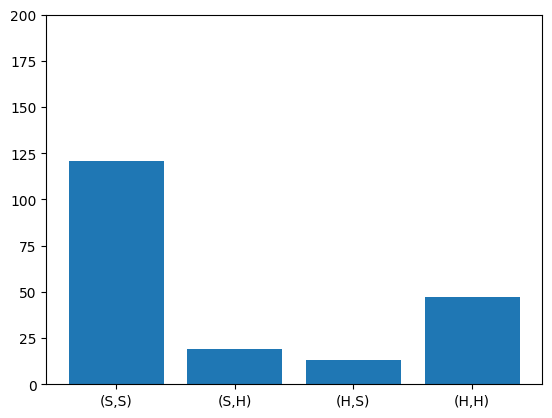

In [13]:
# Visualize the results. Don't modify. 
plot_results(result[0], result[2])

## Problem #3


Revisit your response to Quiz #3, Question #5.3. Add your response below. If there's mismatch with Problem #2, clearly explain what you have learned in the process. If your results are consistent with your expectations, briefly explain the output.

| Quiz #1, Question #5.3 | Briefly explain output OR clearly explain what you have learned | 
|------|------|
|Problem #1 Output| N/A |
|Problem #2 Output| YOUR COMMENTS HERE |

## Before You Submit...

00. Re-read the general instructions provided above, and
01. Hit "Kernel"->"Restart & Run All". The first cell that is run should show [1], the second should show [2], and so on...
02. Submit your notebook (as .ipynb, not PDF) using Gradescope, and
03.  Do not submit any other files.